In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Primer ejemplo") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Data Sources

This chapter formally introduces the variety of other data sources that you can use with Spark out
of the box as well as the countless other sources built by the greater community. Spark has six
“core” data sources and hundreds of external data sources written by the community. The ability
to read and write from all different kinds of data sources and for the community to create its own
contributions is arguably one of Spark’s greatest strengths. Following are Spark’s core data
sources:
* CSV
* JSON
* Parquet
* ORC
* JDBC/ODBC connections
* Plain-text files

As mentioned, Spark has numerous community-created data sources. Here’s just a small sample:
* Cassandra
* HBase
* MongoDB
* AWS Redshift
* XML
* And many, many others

The goal of this chapter is to give you the ability to read and write from Spark’s core data
sources and know enough to understand what you should look for when integrating with thirdparty data sources. To achieve this, we will focus on the core concepts that you need to be able to
recognize and understand.

## The Structure of the Data Sources API
Before proceeding with how to read and write from certain formats, let’s visit the overall
organizational structure of the data source APIs.

### Read API Structure
The core structure for reading data is as follows:

DataFrameReader.format(...).option("key", "value").schema(...).load()

We will use this format to read from all of our data sources. format is optional because by
default Spark will use the Parquet format. option allows you to set key-value configurations to
parameterize how you will read data. Lastly, schema is optional if the data source provides a
schema or if you intend to use schema inference. Naturally, there are some required options for
each format, which we will discuss when we look at each format.

___NOTE___

There is a lot of shorthand notation in the Spark community, and the data source read API is no
exception. We try to be consistent throughout the book while still revealing some of the shorthand
notation along the way.

### Basics of Reading Data
The foundation for reading data in Spark is the DataFrameReader. We access this through the
SparkSession via the read attribute:

spark.read

After we have a DataFrame reader, we specify several values:
* The format
* The schema
* The read mode
* A series of options

The format, options, and schema each return a DataFrameReader that can undergo further
transformations and are all optional, except for one option. Each data source has a specific set of
options that determine how the data is read into Spark (we cover these options shortly). At a
minimum, you must supply the DataFrameReader a path to from which to read.

Here’s an example of the overall layout:
~~~
spark.read.format("csv")
.option("mode", "FAILFAST")
.option("inferSchema", "true")
.option("path", "path/to/file(s)")
.schema(someSchema)
.load()
~~~
There are a variety of ways in which you can set options; for example, you can build a map and
pass in your configurations. For now, we’ll stick to the simple and explicit way that you just saw.

___Read modes___

Reading data from an external source naturally entails encountering malformed data, especially
when working with only semi-structured data sources. Read modes specify what will happen
when Spark does come across malformed records. Table 9-1 lists the read modes.
Table 9-1. Spark’s read modes
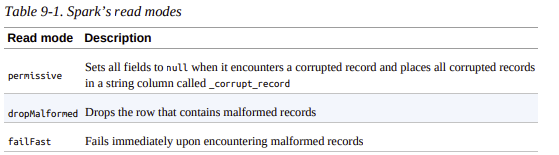
The default is permissive.

### Write API Structure
The core structure for writing data is as follows:

DataFrameWriter.format(...).option(...).partitionBy(...).bucketBy(...).sortBy(
...).save()

We will use this format to write to all of our data sources. format is optional because by default,
Spark will use the arquet format. option, again, allows us to configure how to write out our
given data. PartitionBy, bucketBy, and sortBy work only for file-based data sources; you can
use them to control the specific layout of files at the destination.

### Basics of Writing Data
The foundation for writing data is quite similar to that of reading data. Instead of the
DataFrameReader, we have the DataFrameWriter. Because we always need to write out some
given data source, we access the DataFrameWriter on a per-DataFrame basis via the write
attribute:
~~~
// in Scala
dataFrame.write
~~~
After we have a DataFrameWriter, we specify three values: the format, a series of options,
and the save mode. At a minimum, you must supply a path. We will cover the potential for options, which vary from data source to data source, shortly.
~~~
// in Scala
dataframe.write.format("csv")
.option("mode", "OVERWRITE")
.option("dateFormat", "yyyy-MM-dd")
.option("path", "path/to/file(s)")
.save()
~~~
___Save modes___

Save modes specify what will happen if Spark finds data at the specified location (assuming all
else equal). Table 9-2 lists the save modes.
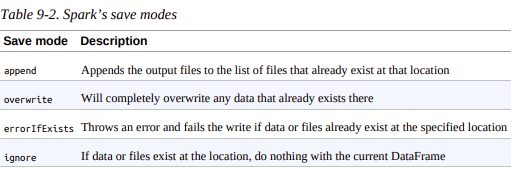
The default is errorIfExists. This means that if Spark finds data at the location to which
you’re writing, it will fail the write immediately.

We’ve largely covered the core concepts that you’re going to need when using data sources, so
now let’s dive into each of Spark’s native data sources.

## CSV Files
CSV stands for commma-separated values. This is a common text file format in which each line
represents a single record, and commas separate each field within a record. CSV files, while
seeming well structured, are actually one of the trickiest file formats you will encounter because
not many assumptions can be made in production scenarios about what they contain or how they
are structured. For this reason, the CSV reader has a large number of options. These options give
you the ability to work around issues like certain characters needing to be escaped—for example,
commas inside of columns when the file is also comma-delimited or null values labeled in an
unconventional way.

### CSV Options
Table 9-3 presents the options available in the CSV reader
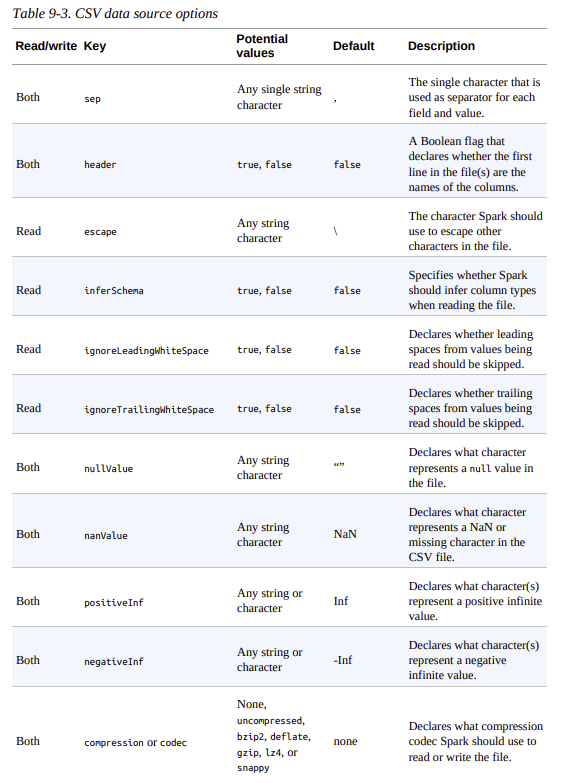
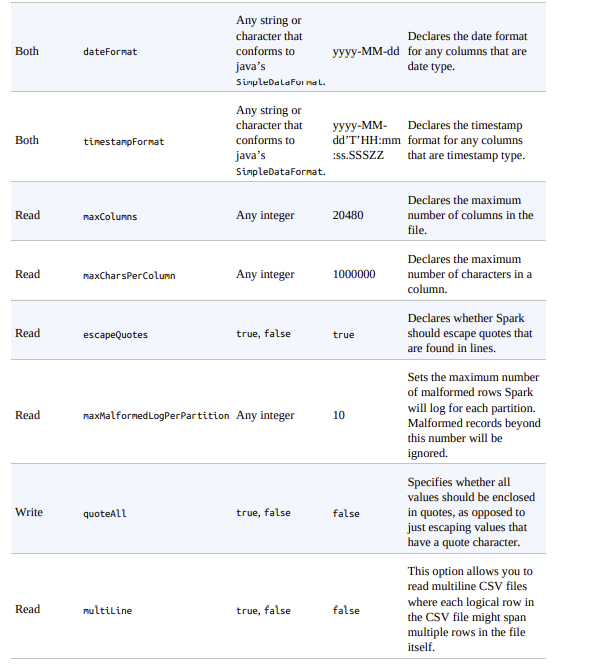


### Reading CSV Files
To read a CSV file, like any other format, we must first create a DataFrameReader for that
specific format. Here, we specify the format to be CSV:
~~~
spark.read.format("csv")
~~~
After this, we have the option of specifying a schema as well as modes as options. Let’s set a
couple of options, some that we saw from the beginning of the book and others that we haven’t
seen yet. We’ll set the header to true for our CSV file, the mode to be FAILFAST, and
inferSchema to true:
~~~
// in Scala
spark.read.format("csv")
.option("header", "true")
.option("mode", "FAILFAST")
.option("inferSchema", "true")
.load("some/path/to/file.csv")
~~~
As mentioned, we can use the mode to specify how much tolerance we have for malformed data.
For example, we can use these modes and the schema that we created in Chapter 5 to ensure that
our file(s) conform to the data that we expected:
~~~
// in Scala
import org.apache.spark.sql.types.{StructField, StructType, StringType, LongType}
val myManualSchema = new StructType(Array(
new StructField("DEST_COUNTRY_NAME", StringType, true),
new StructField("ORIGIN_COUNTRY_NAME", StringType, true),
new StructField("count", LongType, false)
))
spark.read.format("csv")
.option("header", "true")
.option("mode", "FAILFAST")
.schema(myManualSchema)
.load("/data/flight-data/csv/2010-summary.csv")
.show(5)
~~~
Things get tricky when we don’t expect our data to be in a certain format, but it comes in that
way, anyhow. For example, let’s take our current schema and change all column types to
LongType. This does not match the actual schema, but Spark has no problem with us doing this.
The problem will only manifest itself when Spark actually reads the data. As soon as we start our
Spark job, it will immediately fail (after we execute a job) due to the data not conforming to the
specified schema:
~~~
// in Scala
val myManualSchema = new StructType(Array(
new StructField("DEST_COUNTRY_NAME", LongType, true),
new StructField("ORIGIN_COUNTRY_NAME", LongType, true),
new StructField("count", LongType, false) ))
spark.read.format("csv")
.option("header", "true")
.option("mode", "FAILFAST")
.schema(myManualSchema)
.load("/data/flight-data/csv/2010-summary.csv")
.take(5)
~~~
In general, Spark will fail only at job execution time rather than DataFrame definition time—
even if, for example, we point to a file that does not exist. This is due to lazy evaluation, a
concept we learned about in Chapter 2.

### Writing CSV Files
Just as with reading data, there are a variety of options (listed in Table 9-3) for writing data when
we write CSV files. This is a subset of the reading options because many do not apply when
writing data (like maxColumns and inferSchema). Here’s an example:
~~~
// in Scala
val csvFile = spark.read.format("csv")
.option("header", "true").option("mode", "FAILFAST").schema(myManualSchema)
.load("/data/flight-data/csv/2010-summary.csv")
# in Python
csvFile = spark.read.format("csv")\
.option("header", "true")\
.option("mode", "FAILFAST")\
.option("inferSchema", "true")\
.load("/data/flight-data/csv/2010-summary.csv")
~~~
For instance, we can take our CSV file and write it out as a TSV file quite easily:
~~~
// in Scala
csvFile.write.format("csv").mode("overwrite").option("sep", "\t")
.save("/tmp/my-tsv-file.tsv")
# in Python
csvFile.write.format("csv").mode("overwrite").option("sep", "\t")\
.save("/tmp/my-tsv-file.tsv")
~~~
When you list the destination directory, you can see that my-tsv-file is actually a folder with
numerous files within it:
~~~
$ ls /tmp/my-tsv-file.tsv/
/tmp/my-tsv-file.tsv/part-00000-35cf9453-1943-4a8c-9c82-9f6ea9742b29.csv
~~~
This actually reflects the number of partitions in our DataFrame at the time we write it out. If we
were to repartition our data before then, we would end up with a different number of files. We
discuss this trade-off at the end of this chapter.

## JSON Files
Those coming from the world of JavaScript are likely familiar with JavaScript Object Notation,
or JSON, as it’s commonly called. There are some catches when working with this kind of data
that are worth considering before we jump in. In Spark, when we refer to JSON files, we refer to
line-delimited JSON files. This contrasts with files that have a large JSON object or array per
file.

The line-delimited versus multiline trade-off is controlled by a single option: multiLine. When
you set this option to true, you can read an entire file as one json object and Spark will go
through the work of parsing that into a DataFrame. Line-delimited JSON is actually a much more
stable format because it allows you to append to a file with a new record (rather than having to
read in an entire file and then write it out), which is what we recommend that you use. Another
key reason for the popularity of line-delimited JSON is because JSON objects have structure,
and JavaScript (on which JSON is based) has at least basic types. This makes it easier to work
with because Spark can make more assumptions on our behalf about the data. You’ll notice that
there are significantly less options than we saw for CSV because of the objects.

### JSON Options
Table 9-4 lists the options available for the JSON object, along with their descriptions.
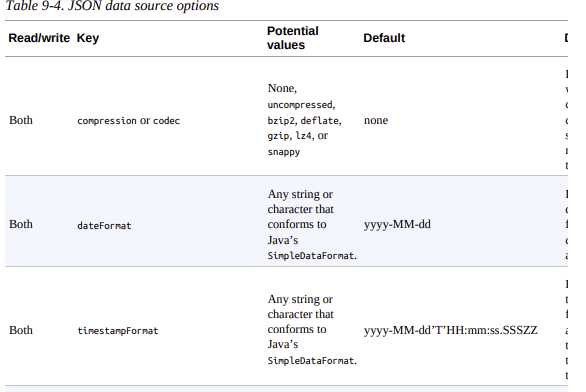
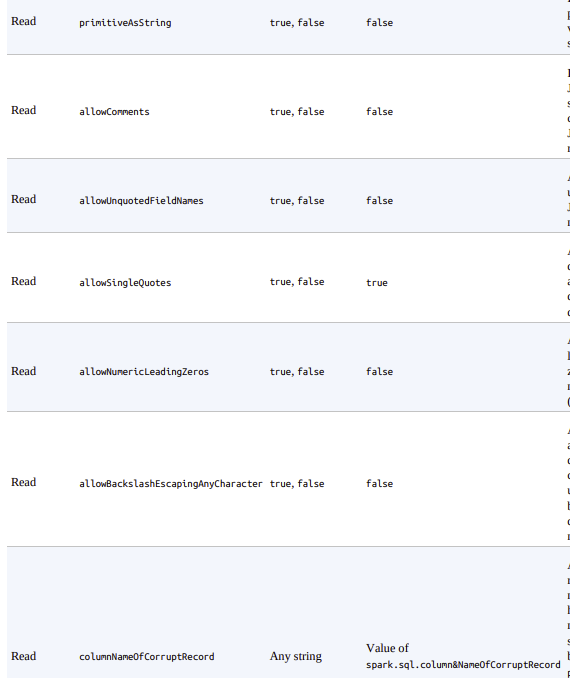
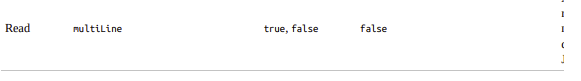
Now, reading a line-delimited JSON file varies only in the format and the options that we
specify:
~~~
spark.read.format("json")
~~~

### Reading JSON Files
Let’s look at an example of reading a JSON file and compare the options that we’re seeing:
~~~
// in Scala
spark.read.format("json").option("mode", "FAILFAST").schema(myManualSchema)
.load("/data/flight-data/json/2010-summary.json").show(5)
# in Python
spark.read.format("json").option("mode", "FAILFAST")\
.option("inferSchema", "true")\
.load("/data/flight-data/json/2010-summary.json").show(5)
~~~

### Writing JSON Files
Writing JSON files is just as simple as reading them, and, as you might expect, the data source
does not matter. Therefore, we can reuse the CSV DataFrame that we created earlier to be the
source for our JSON file. This, too, follows the rules that we specified before: one file per
partition will be written out, and the entire DataFrame will be written out as a folder. It will also
have one JSON object per line:
~~~
// in Scala
csvFile.write.format("json").mode("overwrite").save("/tmp/my-json-file.json")
# in Python
csvFile.write.format("json").mode("overwrite").save("/tmp/my-json-file.json")
$ ls /tmp/my-json-file.json/
/tmp/my-json-file.json/part-00000-tid-543....json
~~~

## Parquet Files
Parquet is an open source column-oriented data store that provides a variety of storage
optimizations, especially for analytics workloads. It provides columnar compression, which
saves storage space and allows for reading individual columns instead of entire files. It is a file
format that works exceptionally well with Apache Spark and is in fact the default file format. We
recommend writing data out to Parquet for long-term storage because reading from a Parquet file
will always be more efficient than JSON or CSV. Another advantage of Parquet is that it
supports complex types. This means that if your column is an array (which would fail with a
CSV file, for example), map, or struct, you’ll still be able to read and write that file without
issue. Here’s how to specify Parquet as the read format:
~~~
spark.read.format("parquet")
~~~

### Reading Parquet Files
Parquet has very few options because it enforces its own schema when storing data. Thus, all you
need to set is the format and you are good to go. We can set the schema if we have strict
requirements for what our DataFrame should look like. Oftentimes this is not necessary because
we can use schema on read, which is similar to the inferSchema with CSV files. However, with
Parquet files, this method is more powerful because the schema is built into the file itself (so no
inference needed).

Here are some simple examples reading from parquet:
~~~
spark.read.format("parquet")
// in Scala
spark.read.format("parquet")
.load("/data/flight-data/parquet/2010-summary.parquet").show(5)
# in Python
spark.read.format("parquet")\
.load("/data/flight-data/parquet/2010-summary.parquet").show(5)
~~~
___Parquet options___

As we just mentioned, there are very few Parquet options—precisely two, in fact—because it has
a well-defined specification that aligns closely with the concepts in Spark. Table 9-5 presents the
options.

___WARNING___

Even though there are only two options, you can still encounter problems if you’re working with
incompatible Parquet files. Be careful when you write out Parquet files with different versions of
Spark (especially older ones) because this can cause significant headache.

Table 9-5. Parquet data source options
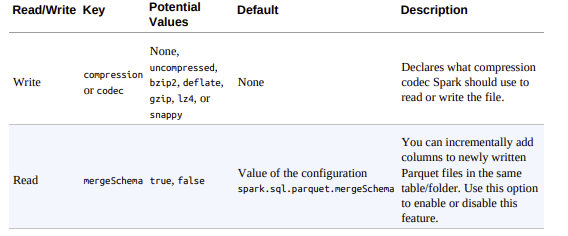

### Writing Parquet Files
Writing Parquet is as easy as reading it. We simply specify the location for the file. The same
partitioning rules apply:
~~~
// in Scala
csvFile.write.format("parquet").mode("overwrite")
.save("/tmp/my-parquet-file.parquet")
# in Python
csvFile.write.format("parquet").mode("overwrite")\
.save("/tmp/my-parquet-file.parquet")
~~~

## ORC Files
ORC is a self-describing, type-aware columnar file format designed for Hadoop workloads. It is
optimized for large streaming reads, but with integrated support for finding required rows
quickly. ORC actually has no options for reading in data because Spark understands the file
format quite well. An often-asked question is: What is the difference between ORC and Parquet?
For the most part, they’re quite similar; the fundamental difference is that Parquet is further
optimized for use with Spark, whereas ORC is further optimized for Hive.

### Reading Orc Files
Here’s how to read an ORC file into Spark:
~~~
// in Scala
spark.read.format("orc").load("/data/flight-data/orc/2010-summary.orc").show(5)
# in Python
spark.read.format("orc").load("/data/flight-data/orc/2010-summary.orc").show(5)
~~~
### Writing Orc Files
At this point in the chapter, you should feel pretty comfortable taking a guess at how to write
ORC files. It really follows the exact same pattern that we have seen so far, in which we specify
the format and then save the file:
~~~
// in Scala
csvFile.write.format("orc").mode("overwrite").save("/tmp/my-json-file.orc")
# in Python
csvFile.write.format("orc").mode("overwrite").save("/tmp/my-json-file.orc")
~~~

## SQL Databases
SQL datasources are one of the more powerful connectors because there are a variety of systems
to which you can connect (as long as that system speaks SQL). For instance you can connect to a
MySQL database, a PostgreSQL database, or an Oracle database. You also can connect to
SQLite, which is what we’ll do in this example. Of course, databases aren’t just a set of raw files,
so there are more options to consider regarding how you connect to the database. Namely you’re
going to need to begin considering things like authentication and connectivity (you’ll need to
determine whether the network of your Spark cluster is connected to the network of your
database system).

To avoid the distraction of setting up a database for the purposes of this book, we provide a
reference sample that runs on SQLite. We can skip a lot of these details by using SQLite,
because it can work with minimal setup on your local machine with the limitation of not being
able to work in a distributed setting. If you want to work through these examples in a distributed
setting, you’ll want to connect to another kind of database.

___A PRIMER ON SQLITE___

SQLite is the most used database engine in the entire world, and for good reason. It’s
powerful, fast, and easy to understand. This is because a SQLite database is just a file. That’s
going to make it very easy for you to get up and running because we include the source file
in the official repository for this book. Simply download that file to your local machine, and
you will be able to read from it and write to it. We’re using SQLite, but all of the code here
works with more traditional relational databases, as well, like MySQL. The primary
difference is in the properties that you include when you connect to the database. When
we’re working with SQLite, there’s no notion of user or password.

___WARNING___
Although SQLite makes for a good reference example, it’s probablu not what you want to use in
production. Also, SQLite will not necessarily work well in a distributed setting because of its
requirement to lock the entire database on write. The example we present here will work in a similar
way using MySQL or PostgreSQL, as well.


To read and write from these databases, you need to do two things: include the Java Database
Connectivity (JDBC) driver for you particular database on the spark classpath, and provide the
proper JAR for the driver itself. For example, to be able to read and write from PostgreSQL, you
might run something like this:
~~~
./bin/spark-shell \
--driver-class-path postgresql-9.4.1207.jar \
--jars postgresql-9.4.1207.jar
~~~
Just as with our other sources, there are a number of options that are available when reading from
and writing to SQL databases. Only some of these are relevant for our current example, but
Table 9-6 lists all of the options that you can set when working with JDBC databases.
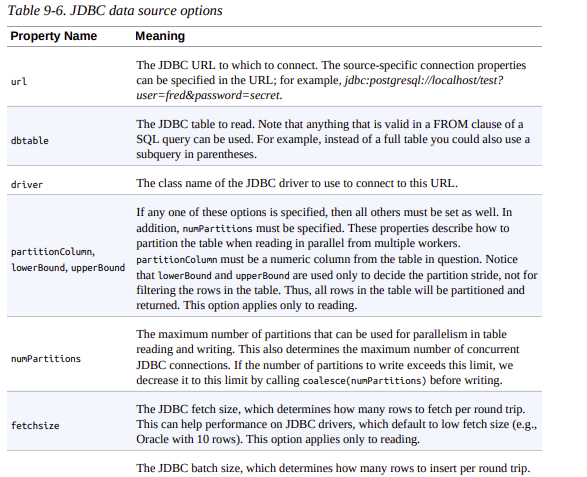
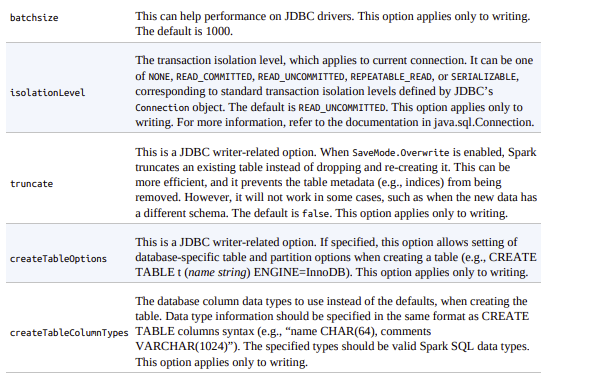

### Reading from SQL Databases
When it comes to reading a file, SQL databases are no different from the other data sources that
we looked at earlier. As with those sources, we specify the format and options, and then load in
the data:
~~~
// in Scala
val driver = "org.sqlite.JDBC"
val path = "/data/flight-data/jdbc/my-sqlite.db"
val url = s"jdbc:sqlite:/${path}"
val tablename = "flight_info"
# in Python
driver = "org.sqlite.JDBC"
path = "/data/flight-data/jdbc/my-sqlite.db"
url = "jdbc:sqlite:" + path
tablename = "flight_info"
~~~
After you have defined the connection properties, you can test your connection to the database
itself to ensure that it is functional. This is an excellent troubleshooting technique to confirm that
your database is available to (at the very least) the Spark driver. This is much less relevant for
SQLite because that is a file on your machine but if you were using something like MySQL, you
could test the connection with the following:
~~~
import java.sql.DriverManager
val connection = DriverManager.getConnection(url)
connection.isClosed()
connection.close()
~~~
If this connection succeeds, you’re good to go. Let’s go ahead and read the DataFrame from the
SQL table:
~~~
// in Scala
val dbDataFrame = spark.read.format("jdbc").option("url", url)
.option("dbtable", tablename).option("driver", driver).load()
# in Python
dbDataFrame = spark.read.format("jdbc").option("url", url)\
.option("dbtable", tablename).option("driver", driver).load()
~~~
SQLite has rather simple configurations (no users, for example). Other databases, like
PostgreSQL, require more configuration parameters. Let’s perform the same read that we just
performed, except using PostgreSQL this time:
~~~
// in Scala
val pgDF = spark.read
.format("jdbc")
.option("driver", "org.postgresql.Driver")
.option("url", "jdbc:postgresql://database_server")
.option("dbtable", "schema.tablename")
.option("user", "username").option("password","my-secret-password").load()
# in Python
pgDF = spark.read.format("jdbc")\
.option("driver", "org.postgresql.Driver")\
.option("url", "jdbc:postgresql://database_server")\
.option("dbtable", "schema.tablename")\
.option("user", "username").option("password", "my-secret-password").load()
~~~
As we create this DataFrame, it is no different from any other: you can query it, transform it, and
join it without issue. You’ll also notice that there is already a schema, as well. That’s because
Spark gathers this information from the table itself and maps the types to Spark data types. Let’s
get only the distinct locations to verify that we can query it as expected:
~~~
dbDataFrame.select("DEST_COUNTRY_NAME").distinct().show(5)
+-----------------+
|DEST_COUNTRY_NAME|
+-----------------+
| Anguilla|
| Russia|
| Paraguay|
| Senegal|
| Sweden|
+-----------------+
~~~
Awesome, we can query the database! Before we proceed, there are a couple of nuanced details
that are worth understanding.

### Query Pushdown
First, Spark makes a best-effort attempt to filter data in the database itself before creating the
DataFrame. For example, in the previous sample query, we can see from the query plan that it
selects only the relevant column name from the table:
~~~
dbDataFrame.select("DEST_COUNTRY_NAME").distinct().explain
== Physical Plan ==
*HashAggregate(keys=[DEST_COUNTRY_NAME#8108], functions=[])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#8108, 200)
+- *HashAggregate(keys=[DEST_COUNTRY_NAME#8108], functions=[])
+- *Scan JDBCRelation(flight_info) [numPartitions=1] ...
~~~
Spark can actually do better than this on certain queries. For example, if we specify a filter on
our DataFrame, Spark will push that filter down into the database. We can see this in the explain
plan under PushedFilters.
~~~
// in Scala
dbDataFrame.filter("DEST_COUNTRY_NAME in ('Anguilla', 'Sweden')").explain
# in Python
dbDataFrame.filter("DEST_COUNTRY_NAME in ('Anguilla', 'Sweden')").explain()
== Physical Plan ==
*Scan JDBCRel... PushedFilters: [*In(DEST_COUNTRY_NAME, [Anguilla,Sweden])],
...
~~~
Spark can’t translate all of its own functions into the functions available in the SQL database in
which you’re working. Therefore, sometimes you’re going to want to pass an entire query into
your SQL that will return the results as a DataFrame. Now, this might seem like it’s a bit
complicated, but it’s actually quite straightforward. Rather than specifying a table name, you just
specify a SQL query. Of course, you do need to specify this in a special way; you must wrap the
query in parenthesis and rename it to something—in this case, I just gave it the same table name:
~~~
// in Scala
val pushdownQuery = """(SELECT DISTINCT(DEST_COUNTRY_NAME) FROM flight_info)
AS flight_info"""
val dbDataFrame = spark.read.format("jdbc")
.option("url", url).option("dbtable", pushdownQuery).option("driver", driver)
.load()
# in Python
pushdownQuery = """(SELECT DISTINCT(DEST_COUNTRY_NAME) FROM flight_info)
AS flight_info"""
dbDataFrame = spark.read.format("jdbc")\
.option("url", url).option("dbtable", pushdownQuery).option("driver", driver)\
.load()
~~~
Now when you query this table, you’ll actually be querying the results of that query. We can see
this in the explain plan. Spark doesn’t even know about the actual schema of the table, just the
one that results from our previous query:
~~~
dbDataFrame.explain()
== Physical Plan ==
*Scan JDBCRelation(
(SELECT DISTINCT(DEST_COUNTRY_NAME)
FROM flight_info) as flight_info
) [numPartitions=1] [DEST_COUNTRY_NAME#788] ReadSchema: ...
~~~
___Reading from databases in parallel___

All throughout this book, we have talked about partitioning and its importance in data
processing. Spark has an underlying algorithm that can read multiple files into one partition, or
conversely, read multiple partitions out of one file, depending on the file size and the
“splitability” of the file type and compression. The same flexibility that exists with files, also
exists with SQL databases except that you must configure it a bit more manually. What you can
configure, as seen in the previous options, is the ability to specify a maximum number of
partitions to allow you to limit how much you are reading and writing in parallel:
~~~
// in Scala
val dbDataFrame = spark.read.format("jdbc")
.option("url", url).option("dbtable", tablename).option("driver", driver)
.option("numPartitions", 10).load()
# in Python
dbDataFrame = spark.read.format("jdbc")\
.option("url", url).option("dbtable", tablename).option("driver", driver)\
.option("numPartitions", 10).load()
~~~
In this case, this will still remain as one partition because there is not too much data. However,
this configuration can help you ensure that you do not overwhelm the database when reading and
writing data:
~~~
dbDataFrame.select("DEST_COUNTRY_NAME").distinct().show()
~~~
There are several other optimizations that unfortunately only seem to be under another API set.
You can explicitly push predicates down into SQL databases through the connection itself. This
optimization allows you to control the physical location of certain data in certain partitions by
specifying predicates. That’s a mouthful, so let’s look at a simple example. We only need data
from two countries in our data: Anguilla and Sweden. We could filter these down and have them
pushed into the database, but we can also go further by having them arrive in their own partitions
in Spark. We do that by specifying a list of predicates when we create the data source:
~~~
// in Scala
val props = new java.util.Properties
props.setProperty("driver", "org.sqlite.JDBC")
val predicates = Array(
"DEST_COUNTRY_NAME = 'Sweden' OR ORIGIN_COUNTRY_NAME = 'Sweden'",
"DEST_COUNTRY_NAME = 'Anguilla' OR ORIGIN_COUNTRY_NAME = 'Anguilla'")
spark.read.jdbc(url, tablename, predicates, props).show()
spark.read.jdbc(url, tablename, predicates, props).rdd.getNumPartitions // 2
# in Python
props = {"driver":"org.sqlite.JDBC"}
predicates = [
"DEST_COUNTRY_NAME = 'Sweden' OR ORIGIN_COUNTRY_NAME = 'Sweden'",
"DEST_COUNTRY_NAME = 'Anguilla' OR ORIGIN_COUNTRY_NAME = 'Anguilla'"]
spark.read.jdbc(url, tablename, predicates=predicates, properties=props).show()
spark.read.jdbc(url,tablename,predicates=predicates,properties=props)\
.rdd.getNumPartitions() # 2
+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
| Sweden| United States| 65|
| United States| Sweden| 73|
| Anguilla| United States| 21|
| United States| Anguilla| 20|
+-----------------+-------------------+-----+
~~~
If you specify predicates that are not disjoint, you can end up with lots of duplicate rows. Here’s
an example set of predicates that will result in duplicate rows:
~~~
// in Scala
val props = new java.util.Properties
props.setProperty("driver", "org.sqlite.JDBC")
val predicates = Array(
"DEST_COUNTRY_NAME != 'Sweden' OR ORIGIN_COUNTRY_NAME != 'Sweden'",
"DEST_COUNTRY_NAME != 'Anguilla' OR ORIGIN_COUNTRY_NAME != 'Anguilla'")
spark.read.jdbc(url, tablename, predicates, props).count() // 510
# in Python
props = {"driver":"org.sqlite.JDBC"}
predicates = [
"DEST_COUNTRY_NAME != 'Sweden' OR ORIGIN_COUNTRY_NAME != 'Sweden'",
"DEST_COUNTRY_NAME != 'Anguilla' OR ORIGIN_COUNTRY_NAME != 'Anguilla'"]
spark.read.jdbc(url, tablename, predicates=predicates, properties=props).count()
~~~
___Partitioning based on a sliding window___

Let’s take a look to see how we can partition based on predicates. In this example, we’ll partition
based on our numerical count column. Here, we specify a minimum and a maximum for both
the first partition and last partition. Anything outside of these bounds will be in the first partition
or final partition. Then, we set the number of partitions we would like total (this is the level of
parallelism). Spark then queries our database in parallel and returns numPartitions partitions.
We simply modify the upper and lower bounds in order to place certain values in certain
partitions. No filtering is taking place like we saw in the previous example:
~~~
// in Scala
val colName = "count"
val lowerBound = 0L
val upperBound = 348113L // this is the max count in our database
val numPartitions = 10
# in Python
colName = "count"
lowerBound = 0L
upperBound = 348113L # this is the max count in our database
numPartitions = 10
~~~
This will distribute the intervals equally from low to high:
~~~
// in Scala
spark.read.jdbc(url,tablename,colName,lowerBound,upperBound,numPartitions,props)
.count() // 255
# in Python
spark.read.jdbc(url, tablename, column=colName, properties=props,
lowerBound=lowerBound, upperBound=upperBound,
numPartitions=numPartitions).count() # 255
~~~

### Writing to SQL Databases
Writing out to SQL databases is just as easy as before. You simply specify the URI and write out
the data according to the specified write mode that you want. In the following example, we
specify overwrite, which overwrites the entire table. We’ll use the CSV DataFrame that we
defined earlier in order to do this:
~~~
// in Scala
val newPath = "jdbc:sqlite://tmp/my-sqlite.db"
csvFile.write.mode("overwrite").jdbc(newPath, tablename, props)
# in Python
newPath = "jdbc:sqlite://tmp/my-sqlite.db"
csvFile.write.jdbc(newPath, tablename, mode="overwrite", properties=props)
Let’s look at the results:
// in Scala
spark.read.jdbc(newPath, tablename, props).count() // 255
# in Python
spark.read.jdbc(newPath, tablename, properties=props).count() # 255
~~~
Of course, we can append to the table this new table just as easily:
~~~
// in Scala
csvFile.write.mode("append").jdbc(newPath, tablename, props)
# in Python
csvFile.write.jdbc(newPath, tablename, mode="append", properties=props)
~~~
Notice that count increases:
~~~
// in Scala
spark.read.jdbc(newPath, tablename, props).count() // 765
# in Python
spark.read.jdbc(newPath, tablename, properties=props).count() # 765
~~~

## Text Files
Spark also allows you to read in plain-text files. Each line in the file becomes a record in the
DataFrame. It is then up to you to transform it accordingly. As an example of how you would do
this, suppose that you need to parse some Apache log files to some more structured format, or
perhaps you want to parse some plain text for natural-language processing. Text files make a
great argument for the Dataset API due to its ability to take advantage of the flexibility of native
types.

### Reading Text Files
Reading text files is straightforward: you simply specify the type to be textFile. With
textFile, partitioned directory names are ignored. To read and write text files according to
partitions, you should use text, which respects partitioning on reading and writing:
~~~
spark.read.textFile("/data/flight-data/csv/2010-summary.csv")
.selectExpr("split(value, ',') as rows").show()
+--------------------+
| rows|
+--------------------+
|[DEST_COUNTRY_NAM...|
|[United States, R...|
...
|[United States, A...|
|[Saint Vincent an...|
|[Italy, United St...|
+--------------------+
~~~
### Writing Text Files
When you write a text file, you need to be sure to have only one string column; otherwise, the
write will fail:
~~~
csvFile.select("DEST_COUNTRY_NAME").write.text("/tmp/simple-text-file.txt")
~~~
If you perform some partitioning when performing your write (we’ll discuss partitioning in the
next couple of pages), you can write more columns. However, those columns will manifest as
directories in the folder to which you’re writing out to, instead of columns on every single file:
~~~
// in Scala
csvFile.limit(10).select("DEST_COUNTRY_NAME", "count")
.write.partitionBy("count").text("/tmp/five-csv-files2.csv")
# in Python
csvFile.limit(10).select("DEST_COUNTRY_NAME", "count")\
.write.partitionBy("count").text("/tmp/five-csv-files2py.csv")
~~~

## Advanced I/O Concepts
We saw previously that we can control the parallelism of files that we write by controlling the
partitions prior to writing. We can also control specific data layout by controlling two things:
bucketing and partitioning (discussed momentarily).
### Splittable File Types and Compression
Certain file formats are fundamentally “splittable.” This can improve speed because it makes it
possible for Spark to avoid reading an entire file, and access only the parts of the file necessary
to satisfy your query. Additionally if you’re using something like Hadoop Distributed File
System (HDFS), splitting a file can provide further optimization if that file spans multiple
blocks. In conjunction with this is a need to manage compression. Not all compression schemes
are splittable. How you store your data is of immense consequence when it comes to making
your Spark jobs run smoothly. We recommend Parquet with gzip compression.
### Reading Data in Parallel
Multiple executors cannot read from the same file at the same time necessarily, but they can read
different files at the same time. In general, this means that when you read from a folder with
multiple files in it, each one of those files will become a partition in your DataFrame and be read
in by available executors in parallel (with the remaining queueing up behind the others).
### Writing Data in Parallel
The number of files or data written is dependent on the number of partitions the DataFrame has
at the time you write out the data. By default, one file is written per partition of the data. This
means that although we specify a “file,” it’s actually a number of files within a folder, with the
name of the specified file, with one file per each partition that is written.

For example, the following code

csvFile.repartition(5).write.format("csv").save("/tmp/multiple.csv")

will end up with five files inside of that folder. As you can see from the list call:
~~~
ls /tmp/multiple.csv
/tmp/multiple.csv/part-00000-767df509-ec97-4740-8e15-4e173d365a8b.csv
/tmp/multiple.csv/part-00001-767df509-ec97-4740-8e15-4e173d365a8b.csv
/tmp/multiple.csv/part-00002-767df509-ec97-4740-8e15-4e173d365a8b.csv
/tmp/multiple.csv/part-00003-767df509-ec97-4740-8e15-4e173d365a8b.csv
/tmp/multiple.csv/part-00004-767df509-ec97-4740-8e15-4e173d365a8b.csv
~~~
___Partitioning___

Partitioning is a tool that allows you to control what data is stored (and where) as you write it.
When you write a file to a partitioned directory (or table), you basically encode a column as a
folder. What this allows you to do is skip lots of data when you go to read it in later, allowing
you to read in only the data relevant to your problem instead of having to scan the complete
dataset. These are supported for all file-based data sources:
~~~
// in Scala
csvFile.limit(10).write.mode("overwrite").partitionBy("DEST_COUNTRY_NAME")
.save("/tmp/partitioned-files.parquet")
# in Python
csvFile.limit(10).write.mode("overwrite").partitionBy("DEST_COUNTRY_NAME")\
.save("/tmp/partitioned-files.parquet")
~~~
Upon writing, you get a list of folders in your Parquet “file”:
~~~
$ ls /tmp/partitioned-files.parquet
...
DEST_COUNTRY_NAME=Costa Rica/
DEST_COUNTRY_NAME=Egypt/
DEST_COUNTRY_NAME=Equatorial Guinea/
DEST_COUNTRY_NAME=Senegal/
DEST_COUNTRY_NAME=United States/
~~~
Each of these will contain Parquet files that contain that data where the previous predicate was
true:
~~~
$ ls /tmp/partitioned-files.parquet/DEST_COUNTRY_NAME=Senegal/
part-00000-tid.....parquet
~~~
This is probably the lowest-hanging optimization that you can use when you have a table that
readers frequently filter by before manipulating. For instance, date is particularly common for a
partition because, downstream, often we want to look at only the previous week’s data (instead
of scanning the entire list of records). This can provide massive speedups for readers.

___Bucketing___

Bucketing is another file organization approach with which you can control the data that is
specifically written to each file. This can help avoid shuffles later when you go to read the data
because data with the same bucket ID will all be grouped together into one physical partition.
This means that the data is prepartitioned according to how you expect to use that data later on,
meaning you can avoid expensive shuffles when joining or aggregating.

Rather than partitioning on a specific column (which might write out a ton of directories), it’s
probably worthwhile to explore bucketing the data instead. This will create a certain number of
files and organize our data into those “buckets”:
~~~
val numberBuckets = 10
val columnToBucketBy = "count"
csvFile.write.format("parquet").mode("overwrite")
.bucketBy(numberBuckets, columnToBucketBy).saveAsTable("bucketedFiles")
$ ls /user/hive/warehouse/bucketedfiles/
part-00000-tid-1020575097626332666-8....parquet
part-00000-tid-1020575097626332666-8....parquet
part-00000-tid-1020575097626332666-8....parquet
...
~~~
Bucketing is supported only for Spark-managed tables. For more information on bucketing and
partitioning, watch this talk from Spark Summit 2017.
### Writing Complex Types
As we covered in Chapter 6, Spark has a variety of different internal types. Although Spark can
work with all of these types, not every single type works well with every data file format. For
instance, CSV files do not support complex types, whereas Parquet and ORC do.
### Managing File Size
Managing file sizes is an important factor not so much for writing data but reading it later on.
When you’re writing lots of small files, there’s a significant metadata overhead that you incur
managing all of those files. Spark especially does not do well with small files, although many file
systems (like HDFS) don’t handle lots of small files well, either. You might hear this referred to
as the “small file problem.” The opposite is also true: you don’t want files that are too large
either, because it becomes inefficient to have to read entire blocks of data when you need only a
few rows.

Spark 2.2 introduced a new method for controlling file sizes in a more automatic way. We saw
previously that the number of output files is a derivative of the number of partitions we had at
write time (and the partitioning columns we selected). Now, you can take advantage of another
tool in order to limit output file sizes so that you can target an optimum file size. You can use the
maxRecordsPerFile option and specify a number of your choosing. This allows you to better
control file sizes by controlling the number of records that are written to each file. For example,
if you set an option for a writer as df.write.option("maxRecordsPerFile", 5000), Spark
will ensure that files will contain at most 5,000 records.

## Conclusion
In this chapter we discussed the variety of options available to you for reading and writing data
in Spark. This covers nearly everything you’ll need to know as an everyday user of Spark. For
the curious, there are ways of implementing your own data source; however, we omitted
instructions for how to do this because the API is currently evolving to better support Structured
Streaming. If you’re interested in seeing how to implement your own custom data sources, the
Cassandra Connector is well organized and maintained and could provide a reference for the
adventurous.
In Chapter 10, we discuss Spark SQL and how it interoperates with everything else we’ve seen
so far in the Structured APIs.